# Imports

In [8]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from openai import OpenAI
from colorama import Fore, Style
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [9]:
%load_ext autoreload
%autoreload 2
from churn.packages.data import clean_data
from churn.packages.preprocess import preprocess_features
from churn.packages.params import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# Data
data = pd.read_csv('raw_data/Telco-Customer-Churn.csv')

# Data Exploration

In [11]:
df = data.copy()

In [12]:
len(df)

7043

In [13]:
df = df.drop_duplicates()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [15]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## Feature Exploration

In [16]:
df['gender'].value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

In [17]:
df['SeniorCitizen'].value_counts()

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

In [18]:
df['Partner'].value_counts()

Partner
No     3641
Yes    3402
Name: count, dtype: int64

In [19]:
df['Dependents'].value_counts()

Dependents
No     4933
Yes    2110
Name: count, dtype: int64

In [20]:
df['tenure'].value_counts()

tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64

In [21]:
df['PhoneService'].value_counts()

PhoneService
Yes    6361
No      682
Name: count, dtype: int64

In [22]:
df['MultipleLines'].value_counts()

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

In [23]:
df['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

In [24]:
df['OnlineSecurity'].value_counts()

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

In [25]:
df['OnlineBackup'].value_counts()

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

In [26]:
df['DeviceProtection'].value_counts()

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

In [27]:
df['TechSupport'].value_counts()

TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64

In [28]:
df['StreamingTV'].value_counts()

StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64

In [29]:
df['StreamingMovies'].value_counts()

StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64

In [30]:
df['Contract'].value_counts()

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [31]:
df['PaperlessBilling'].value_counts()

PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

In [32]:
df['PaymentMethod'].value_counts()

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [33]:
df['MonthlyCharges'].value_counts()

MonthlyCharges
20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
23.65      1
114.70     1
43.65      1
87.80      1
78.70      1
Name: count, Length: 1585, dtype: int64

In [34]:
df['TotalCharges'].value_counts()

TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64

## Feature Types

### Continuous

In [35]:
cont = ['MonthlyCharges', 'tenure', 'TotalCharges']

### Binary

In [36]:
bin = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneSerivce', 'PaperlessBilling']

### Categorical

In [37]:
cat = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

## Feature Editing

In [38]:
edit = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

In [39]:
for i in edit:
    df[i] = df[i].apply(lambda x: 'No' if x != 'Yes' else 'Yes')

In [40]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [41]:
yes_no = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

In [42]:
for i in yes_no:
    df[i] = df[i].apply(lambda x: 0 if x == 'No' else 1)
df['Churn'] = df['Churn'].apply(lambda x: 0 if x == 'No' else 1)

In [43]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [44]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,0,DSL,0,...,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,DSL,1,...,1,0,0,0,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,1,0,0,0,2,1,0,DSL,1,...,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1


## Correlation

In [45]:
df_corr = df.drop(columns=['customerID', 'Contract', 'PaymentMethod', 'InternetService', 'TotalCharges'])

In [46]:
df_corr

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,Churn
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,0
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,0,1,1,1,1,1,84.80,0
7039,0,0,1,1,72,1,1,0,1,1,0,1,1,1,103.20,0
7040,0,0,1,1,11,0,0,1,0,0,0,0,0,1,29.60,0
7041,1,1,1,0,4,1,1,0,0,0,0,0,0,1,74.40,1


<Axes: >

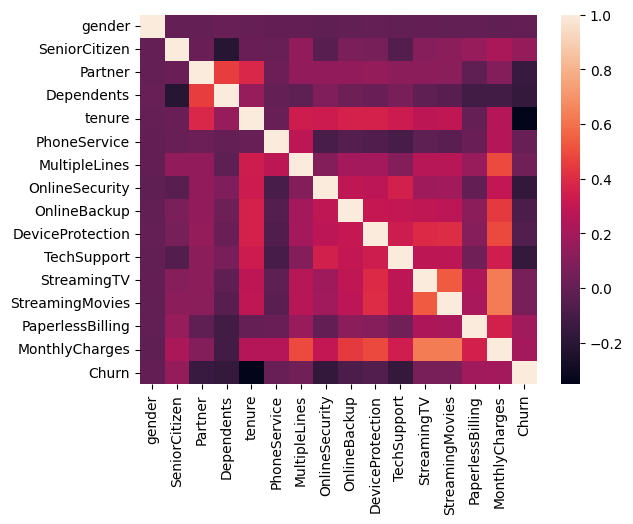

In [47]:
sns.heatmap(df_corr.corr())

# Preprocessing

In [48]:
print(cont)

['MonthlyCharges', 'tenure', 'TotalCharges']


<Axes: xlabel='MonthlyCharges', ylabel='Count'>

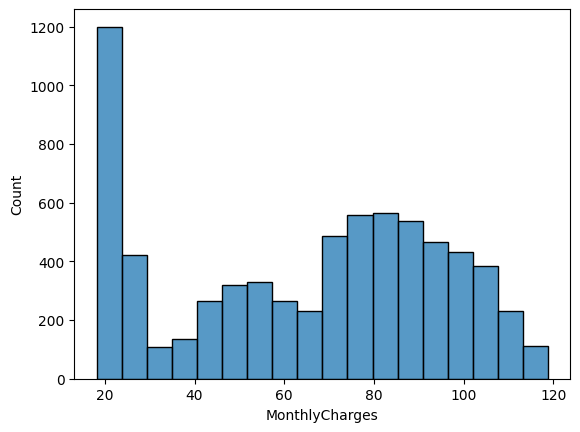

In [49]:
sns.histplot(df['MonthlyCharges'])

<Axes: xlabel='tenure', ylabel='Count'>

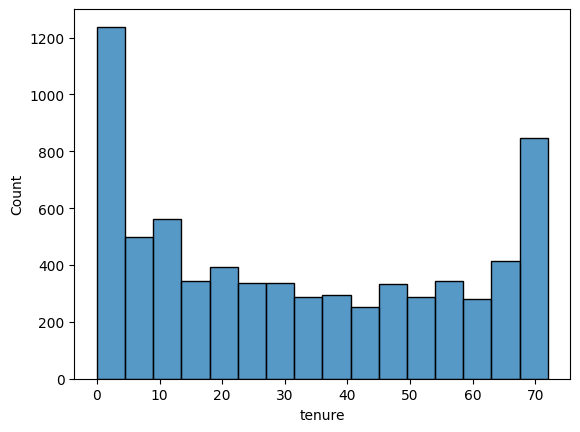

In [50]:
sns.histplot(df['tenure'])

Going to create a MinMax to have it statelss

# Functions

In [51]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,0,DSL,0,...,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,DSL,1,...,1,0,0,0,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,1,0,0,0,2,1,0,DSL,1,...,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,0,DSL,1,...,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,Fiber optic,0,...,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,24,1,1,DSL,1,...,1,1,1,1,One year,1,Mailed check,84.80,1990.5,0
7039,2234-XADUH,0,0,1,1,72,1,1,Fiber optic,0,...,1,0,1,1,One year,1,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,0,0,1,1,11,0,0,DSL,1,...,0,0,0,0,Month-to-month,1,Electronic check,29.60,346.45,0
7041,8361-LTMKD,1,1,1,0,4,1,1,Fiber optic,0,...,0,0,0,0,Month-to-month,1,Mailed check,74.40,306.6,1


In [52]:
df_2 = clean_data(df)

In [53]:
y = df_2['Churn']
X = df_2.drop(columns=['Churn','customerID'])

In [54]:
X.shape

(7043, 18)

In [55]:
X_preprocessed = preprocess(X)

NameError: name 'preprocess' is not defined

In [ ]:
model = LogisticRegression(penalty='elasticnet', l1_ratio=0.3, solver='saga')

In [ ]:
model.fit(X=X_preprocessed, y=y)

LogisticRegression(l1_ratio=0.3, penalty='elasticnet', solver='saga')

In [ ]:
cv = cross_validate(model, X_preprocessed, y, scoring=['accuracy', 'precision'], cv=5, n_jobs=-1)

In [ ]:
cv

{'fit_time': array([0.02353787, 0.02797699, 0.02626324, 0.02273703, 0.02455902]),
 'score_time': array([0.00149918, 0.00176716, 0.00167966, 0.00194287, 0.00153112]),
 'test_accuracy': array([0.80340667, 0.79843861, 0.78495387, 0.79119318, 0.79616477]),
 'test_precision': array([0.65901639, 0.65306122, 0.62633452, 0.62783172, 0.65934066])}

# gcloud

In [56]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [65]:
date = datetime.date.today()
month_year = date.strftime('%Y-%m')
data.insert(1, 'Date', month_year)

In [69]:
data.to_csv('raw_data/customers_07_2024.csv', index=False)

In [72]:
# Re-run the process to generate the CSV file
file_path = 'local_data/customers_07_2024.csv'
df = pd.read_csv(file_path)

# Modify the Date column to be all 2024-06
df['Date'] = '2024-05'

# Generate artificial data similar to the original data
def generate_artificial_data(df, num_rows):
    artificial_data = pd.DataFrame()

    for column in df.columns:
        if df[column].dtype == 'object':
            artificial_data[column] = np.random.choice(df[column].unique(), num_rows)
        else:
            artificial_data[column] = np.random.choice(df[column].values, num_rows)

    return artificial_data

# Generate 100 rows of artificial data
num_rows = 2000
artificial_data = generate_artificial_data(df, num_rows)

# Save the artificial data to a CSV file
file_save_path = 'local_data/customers_05_2024.csv'
artificial_data.to_csv(file_save_path, index=False)

file_save_path

'local_data/customers_05_2024.csv'